<div style="border:solid Chocolate 2px; padding: 40px">
    
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

## Содержание
* [Загрузка и предобработка данных](#chapter1)
* [Исследовательский анализ данных](#chapter2)
* [Построение модели прогнозирования оттока клиентов](#chapter3)
* [Кластеризация клиентов](#chapter4)
* [Общие выводы](#chapter5)

In [1]:
import pandas as pd
import numpy as np
import datetime 
from datetime import timedelta

from scipy import stats as st

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans



## Загрузка и предобработка данных <a class ="anchor" id="chapter1"></a>

In [2]:
try:
    df = pd.read_csv('/Users/osd/Downloads/gym_churn.csv')
except:     
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.columns = df.columns.str.lower()

Предоставленный датасет содержит записи о четырех тысячах клиентов по 14-ти характеристикам. Пропусков и дубликатов в наборе данных нет. Колонки корректно размечены по типам. Название полей приведено к нижнему регистру.

## Исследовательский анализ данных <a class ="anchor" id="chapter2"></a>

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Полей с пропущенными значениями признаков нет. Столбцов со строковой классификацией - тоже, что облегчает подготовку данных для прогнозирования. 7 из 13 полей содержат бинарные значения (0 или 1).

**Средний возраст клиентов фитнес-клуба составляет 29 лет. Средний период действия абонемента - почти пять месяцев при медиане - один месяц**. Значит не менее половины клиентов имеют месячный контракт, несмотря на довольно высокий уровень среднего показателя. Большинство посетителей живут рядом с клубом. Гендерно клиенты распределены примерно поровну.

In [9]:
churn_mean = df.groupby('churn').agg('mean').reset_index()
churn_mean

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Среди тех, кто перестал пользоваться услугами клуба значительно меньше тех, кто является сотрудником организации-партнера клуба (36% против 54% среди тех, кто продолжает посещать), а также тех, кто покупал абонемент по скидке от друга (18 против 35%)**. У "отвалившихся" клиентов значительно меньше средний срок абонемента, они меньше посещают групповые занятия, немного младше (27 против 30 лет), меньше тратят на сопутствующие услуги и в среднем являлись клиентом клуба около месяца против почти 5 месяцев у действующих посетителей клуба. Кроме того, ушедшие клиенты значительно реже посещали спортзал (1,5 против 2 раз в неделю у действующих клиентов). 

In [10]:
#Делим фрейм критерию ухода клиента
df_churn_0 = df.query('churn == 0')
df_churn_1 = df.query('churn == 1')

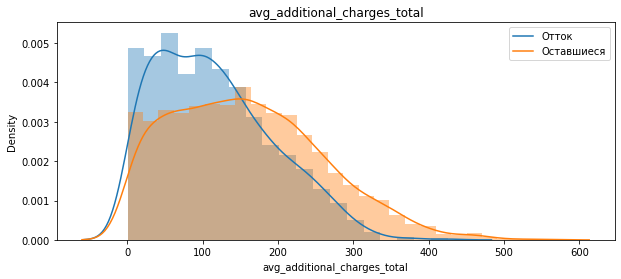

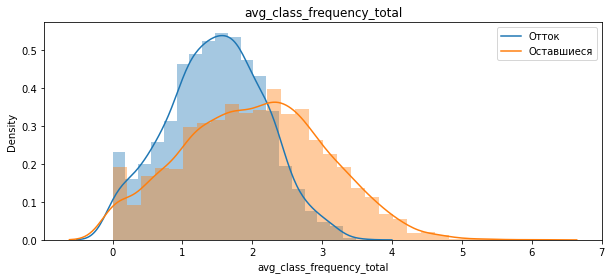

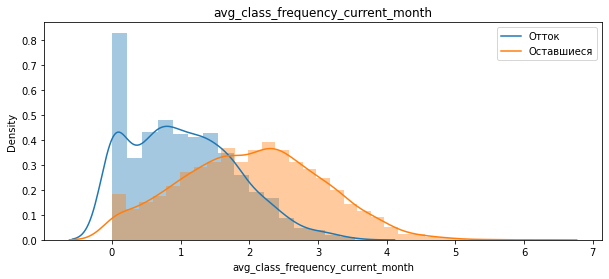

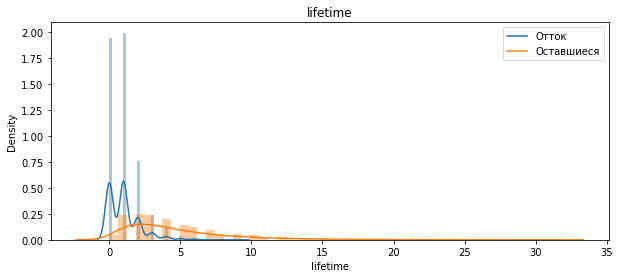

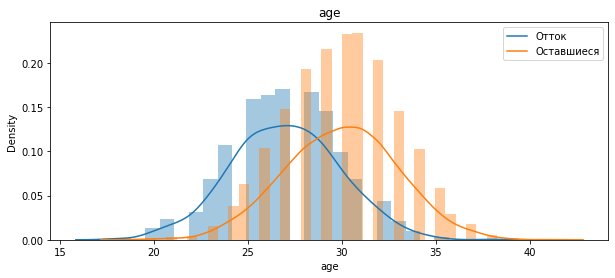

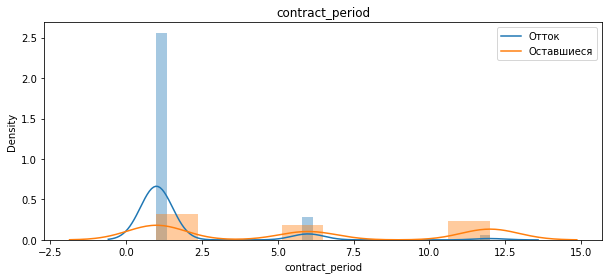

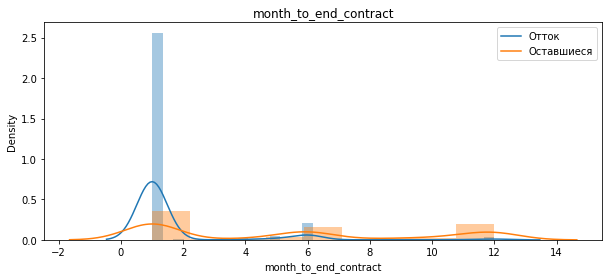

In [12]:
#в цикле строим гистограммы для ушедштих клиентов

left = df[df['churn']==1]
stayed = df[df['churn']==0]
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']

for column in distplot_columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(left[column])
    sns.distplot(stayed[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

Как видно на гистограммах, в основном у уходящих клиентов **абонементы на один месяц** , **почти четверть из них не посещали групповые занятия, они пользуются услугами клуба в основном два и менее месяца**. Большинство из них ходят заниматься менее двух раз в неделю. Похоже, что большинство "отвалившихся" клиентов были спонтанными покупателями месячных абонементов.

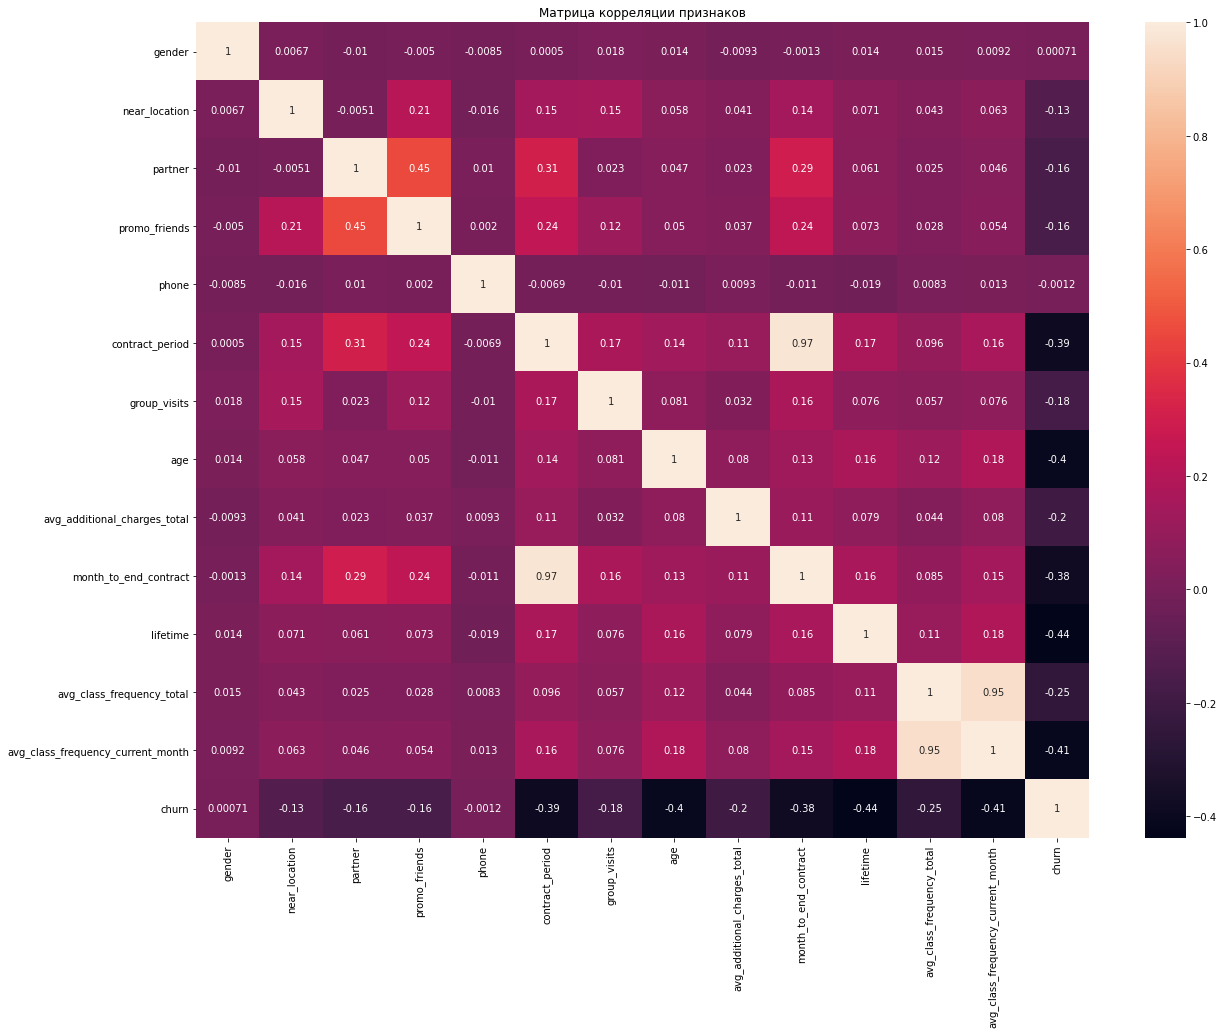

In [14]:
#построим хитмап матрицы коррелыции показателей
plt.figure(figsize=(20,15))
df_corr = df.corr()
sns.heatmap(df_corr,annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

На хитмапе видно, что у **показателя churn значительная корреляция со сроком контракта(-0.39), возрастом(-0.4), длительностью посещения зала (-0.44) и посещением клуба на протяжении последнего месяца (-0.41)**.


## Построение модели прогнозирования оттока клиентов <a class ="anchor" id="chapter3"></a>

In [15]:

print(f'В выборке {len(df.query("churn == 0"))} действующих клиентов и {len(df.query("churn == 1"))} ушедших криентов')

В выборке 2939 действующих клиентов и 1061 ушедших криентов


Число клиентов с двумя разными значениями параметра churn сопоставимо и можно проводить разделение выборки и обучение моделей.

In [16]:
#сформируем вектор признаков и вектор целевой переменной
X = df.drop('churn',axis=1)
y = df['churn'] 

In [17]:
#разделим выборку на целевую и валидационную переменные
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
#обучаем модель логической регрессии
model_reg = LogisticRegression(solver='liblinear',random_state=0)
model_reg.fit(X_train,y_train)
predictions = model_reg.predict(X_test)


In [19]:
#рассчитываем метрики для прогноза логической регрессии
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test,predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test,predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [20]:
#обучаем модель алгоритмом случайного леса и делаем прогноз
random_f_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

random_f_model.fit(X_train, y_train)

random_f_predictions = random_f_model.predict(X_test)

In [21]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,random_f_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test,random_f_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test,random_f_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


In [22]:
#дополнительно применим алгоритм ближайших соседей
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,knn_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test,knn_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test,knn_pred)))

Accuracy: 0.82
Precision: 0.69
Recall: 0.48


In [24]:
#стандартизируем данные и переобучим модели на стандартизированных данных
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [25]:
#логистическая регрессия
model_reg = LogisticRegression(solver='liblinear',random_state=0)
model_reg.fit(X_train,y_train)
predictions = model_reg.predict(X_test)
#случайный лес
random_f_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
random_f_model.fit(X_train_st, y_train)
random_f_predictions = random_f_model.predict(X_test_st)
#ближайшие соседи
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_st, y_train)
knn_pred = knn.predict(X_test_st)


In [26]:
#пересчитаем метрики
print('Логистическая регрессия')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test,predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test,predictions)))
print('Случайный лес')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,random_f_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test,random_f_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test,random_f_predictions)))
print('Ближайшие соседи')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,knn_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test,knn_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test,knn_pred)))

Логистическая регрессия
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
Случайный лес
Accuracy: 0.92
Precision: 0.84
Recall: 0.81
Ближайшие соседи
Accuracy: 0.89
Precision: 0.78
Recall: 0.77


Модели логической регрессии и случайного леса показали примерно одинаковую эффективность по метрикам Accuracy, Precision и Recall до и посде стандартизации. **Впрочем по двум последним показателям у модели логической регресии метрики лучше, поэтому предпочтение стоит отдать ей**. Алгоритм ближайших соседей показался значительно хуже двух других. При этом он оказался очень чувствителен к нестандартизированным данным и показал на них низкую точность прогноза.

## Кластеризация клиентов <a class ="anchor" id="chapter4"></a>

In [27]:
#стандартизируем данные таблицы признаков
scaler = StandardScaler()
scaler.fit(X)
X_st = scaler.transform(X)

In [28]:
#строим маитрицу расстояний
linked = linkage(X_st, method = 'ward') 

In [ ]:
#строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба')
plt.show() 

Дендраграмма предлагает разделить клиентов на **четыре кластера**, но будем делить на пять, как указано в задании.

In [ ]:
#разбиваем выборку на кластеры
km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(X_st)

In [ ]:
#добавляем номера кластеров в основной датафрейм
df['cluster_number'] = labels

In [ ]:
#смотрим средние значения признаков по кластерам
df.groupby('cluster_number').mean()

Кластеры заметно отличаются между собой по средним зачениям признаков promo_friends, contract_period, group_visits, month_to_end_contract, также по avg_class_frequency_current_month - числу посещений клуба в последний месяц. **В кластере с максимальным значением данного параметра (номер четыре) средний churn - менее 7%. И наоборот, в кластере с самым низким числом посещений в последний месяц средний churn более 50%**. Из анализа данных по кластерам можно сделать вывод, что люди посещающие клуб два и более раз в неделю редко прекращают действие контракта. Если же среднее число тренировок заметно снижается ниже двух, то churn резко начинает расти.

In [ ]:
#построим пайчарт с долями кластеров во всей выборке
colors = sns.color_palette('flare')
labels = df.groupby('cluster_number').count().index
plt.figure(figsize=(7, 7)) 
plt.pie(df.groupby('cluster_number').count()['churn'],radius=1,colors=colors,labels=labels,autopct='%.0f%%')
plt.title('Доли кластеров во всей выборке')
plt.show()

In [ ]:
#Строим распределения признаков для кластеров
plt.figure(figsize=(30,90))
for i, col in enumerate(df.drop(['churn', 'cluster_number'], axis=1).columns):
    for cluster in np.sort(df['cluster_number'].unique()):
        sns.histplot(data=df[df['cluster_number']==cluster], x=col,hue='churn', ax=plt.subplot(14, 5, (cluster+1)+i*5))
        plt.title(r"Кластер " + str(cluster))

**Можно выделить две группы кластеров близких по параметрам клиентов: второй-третий и первый-четвертый**.

В третьем кластере сосредоточены люди, которые живут рядом с клубом, с самой большой долей договоров сроком на месяц, значительно реже посещающих групповые занятия, чем в других кластерах. **Распределение по возрастам в нем смещено в сторону 25 лет, в то время как средняя распределения в других кластерах ближе к 30 годам. Общее число занятий колеблется от 1 до 1,5 в неделю, а в последний месяц смещено в направлении нуля**. Параметры клиентов во втором кластере близки к параметрам третьего. В нулевом и четвертом кластере сосредоточены люди с отличающимися характеристиками. Середина распределения смещена в зону более 30 лет, они заметно больше тратят на дополнительные услуги и занимаются два и более раз в неделю. В первом кластере много людей, пришедших в клуб по партнерским программам и промо от друзей.

In [ ]:
#Строим график доли ушедших клиентов по кластерам
churn_rate = df.groupby('cluster_number').mean()['churn'].reset_index()
plt.figure(figsize=(10,7))
plt.title('Доли ушедших клиентов в каждом кластере')
sns.barplot(x = 'cluster_number', y = 'churn', data=churn_rate,palette="flare")
plt.show()

Нулевой и четвертый кластеры, на сходство поведения клиентов в которых указывалось ранее, обладают наименьшим оттоком клиентов. Максимальный отток - во втором и третьем кластерах (также схожих).

***Работа по удержанию клиентов должна проводиться в первую очередь в отношении клиентов с характеристиками людей из второго и третьего кластеров. А именно людей, посещающих зал менее двух раз в неделю, в возрасте менее 27 лет и имеющих контракт на один месяц***.

Вероятно, многие из уходящих клиентов приобрели месячный абонемент спонтанно, не имея выработанной привычки. **Поэтому клубу стоит предпринять усилия для их вовлечения в спортивный образ жизни, чтобы повысить число еженедельных тренировок до двух**. Например, путем предоставления больших скидок на индивидуальные тренировки с тренером или активного приглашения на групповые занятия. **Если человек вовлекается в групповые занятия, ему не будет одиноко в зале, то вероятность продления абонемента вырастет**. 

**Если человек начинает заниматься в среднем менее 1,5 раз в неделю, то скоро он может покинуть клуб. С приближением числа занятий к одному занятию в неделю, клубу нужно максимально нарастить маркетинговую активность, напоминая клиенту о необходимости поддерживать себя в форме, предлагая комфортные для не интенсивно занимающегося человека и понятные планы индивидуальных занятий и детально расписывая характеристики и преимущества бесплатных групповых занятий**. Если групповые занятия являются платными, то необходимо предоставить на них значительную скидку или предложить несколько бесплатных посещений. 

Также рекомендуется организовывать групповые встречи с инструкторами для новичков (посещают зал менее двух месяцев), на которых можно получить рекомендации по питанию и получению "быстрых" первых результатов. Заметив их, весьма вероятно человек вовлечется в занятия спортом и на второй месяц ради экономии купит уже 6 или 12-месячный абонемент.



## Общие выводы <a class ="anchor" id="chapter5"></a>

1. Предоставленный датасет содержит записи о четырех тысячах клиентов по 14-ти характеристикам. Пропусков и дубликатов в наборе данных нет. Колонки корректно размечены по типам. Название полей приведено к нижнему регистру. Полей с пропущенными значениями признаков нет. Столбцов со строковой классификацией - тоже, что облегчает подготовку данных для прогнозирования. 7 из 13 полей содержат бинарные значения (0 или 1).

2. **Средний возраст клиентов фитнес-клуба составляет 29 лет. Средний период действия абонемента - почти пять месяцев при медиане - один месяц**. Значит не менее половины клиентов имеют месячный контракт, несмотря на довольно высокий уровень среднего показателя. Большинство посетителей живут рядом с клубом. Гендерно клиенты распределены примерно поровну.

3. **Среди тех, кто перестал пользоваться услугами клуба значительно меньше тех, кто является сотрудником организации-партнера клуба (36% против 54% среди тех, кто продолжает посещать), а также тех, кто покупал абонемент по скидке от друга (18 против 35%)**. У "отвалившихся" клиентов значительно меньше средний срок абонемента, они меньше посещают групповые занятия, немного младше (27 против 30 лет), меньше тратят на сопутствующие услуги и в среднем являлись клиентом клуба около месяца против почти 5 месяцев у действующих посетителей клуба. Кроме того, ушедшие клиенты значительно реже посещали спортзал (1,5 против 2 раз в неделю у действующих клиентов). 

4. В основном у уходящих клиентов **абонементы на один месяц** , **почти четверть из них не посещали групповые занятия, они пользуются услугами клуба в основном два и менее месяца**. Большинство из них ходят заниматься менее двух раз в неделю. Похоже, что большинство "отвалившихся" клиентов были спонтанными покупателями месячных абонементов.

5. **У показателя churn значительная корреляция со сроком контракта(-0.39), возрастом(-0.4), длительностью посещения зала (-0.44) и посещением клуба на протяжении последнего месяца (-0.41)**

6. Модели логической регрессии и случайного леса показали примерно одинаковую эффективность по метрикам Accuracy, Precision и Recall до и после стандартизации. **Впрочем по двум последним показателям у модели логической регрессии метрики лучше, поэтому предпочтение стоит отдать ей**. Алгоритм ближайших соседей показался значительно хуже двух других. При этом он оказался очень чувствителен к не стандартизированным данным и показал на них низкую точность прогноза. 

7. **Можно выделить две группы кластеров близких по параметрам клиентов: второй-третий и первый-четвертый**. В третьем кластере сосредоточены люди, которые живут рядом с клубом, с самой большой долей договоров сроком на месяц, значительно реже посещающих групповые занятия, чем в других кластерах. **Распределение по возрастам в нем смещено в сторону 25 лет, в то время как средняя распределения в других кластерах ближе к 30 годам. Общее число занятий колеблется от 1 до 1,5 в неделю, а в последний месяц смещено в направлении нуля**. Параметры клиентов во втором кластере близки к параметрам третьего. В нулевом и четвертом кластере сосредоточены люди с отличающимися характеристиками. Середина распределения смещена в зону более 30 лет, они заметно больше тратят на дополнительные услуги и занимаются два и более раз в неделю. В первом кластере много людей, пришедших в клуб по партнерским программам и промо от друзей.Нулевой и четвертый кластеры, на сходство поведения клиентов в которых указывалось ранее, обладают наименьшим оттоком клиентов. Максимальный отток - во втором и третьем кластерах (также схожих).

***Рекомендации. Работа по удержанию клиентов должна проводиться в первую очередь в отношении клиентов с характеристиками людей из второго и третьего кластеров. А именно людей, посещающих зал менее двух раз в неделю, в возрасте менее 27 лет и имеющих контракт на один месяц***.

Вероятно, многие из уходящих клиентов приобрели месячный абонемент спонтанно, не имея выработанной привычки. **Поэтому клубу стоит предпринять усилия для их вовлечения в спортивный образ жизни, чтобы повысить число еженедельных тренировок до двух**. Например, путем предоставления больших скидок на индивидуальные тренировки с тренером или активного приглашения на групповые занятия. **Если человек вовлекается в групповые занятия, ему не будет одиноко в зале, то вероятность продления абонемента вырастет**. 

**Если человек начинает заниматься в среднем менее 1,5 раз в неделю, то скоро он может покинуть клуб. С приближением числа занятий к одному занятию в неделю, клубу нужно максимально нарастить маркетинговую активность, напоминая клиенту о необходимости поддерживать себя в форме, предлагая комфортные для не интенсивно занимающегося человека и понятные планы индивидуальных занятий и детально расписывая характеристики и преимущества бесплатных групповых занятий**. Если групповые занятия являются платными, то необходимо предоставить на них значительную скидку или предложить несколько бесплатных посещений. 

Также рекомендуется организовывать групповые встречи с инструкторами для новичков (посещают зал менее двух месяцев), на которых можно получить рекомендации по питанию и получению "быстрых" первых результатов. Заметив их, вероятно человек вовлечется в занятия спортом и на второй месяц ради экономии купит уже 6 или 12-месячный абонемент.